### Task 2: Time-series image classification

In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
CURR_DIR = os.path.dirname('__file__')
ROOT_DIR=os.path.join(os.getcwd() ,'..')
sys.path.append(ROOT_DIR)

In [2]:
import pandas as pd
from torchvision import transforms

from utilities.dataloader import check_and_update_csv, split_train_val_test_t2, ConstructionDataset

## Task 0: Data loading

Task 0.1 Data cleaning
1. remove entries which do not exist
2. Visualize data distribution

In [3]:
data_dir = '../data' 
img_dir = os.path.join(data_dir, 'foundation_images/foundation_images')

##### Run the below code if running for the first time ######
##--> removes entries in the stage_labels.csv which do not exist and
##--> stores them in stage_labels_corr.csvs
# csv_file_path = os.path.join(data_dir,'stage_labels.csv')
# new_csv_file_path = os.path.join(data_dir,'stage_labels_corr.csv')

# check_and_update_csv(old_csv=csv_file_path, new_csv=new_csv_file_path, img_folders=img_dir)

In [4]:
dataframe = pd.read_csv(os.path.join(data_dir, 'stage_labels_corr.csv'),sep=";")

# Extract camera index, timestamp, and structure index from the filename
dataframe['camera'] = dataframe['imagename'].apply(lambda x: x.split('_')[0])
dataframe['timestamp'] = dataframe['imagename'].apply(lambda x: x.split('_')[1][1:])
dataframe['structure_index'] = dataframe['imagename'].apply(lambda x: int(x.split('_')[2].split('.')[0]))
dataframe['numbered_label'] = dataframe['label'].apply(lambda x: int(x.split('-')[1][0]))

In [ ]:
d = dataframe[dataframe["structure_index"]==0]
d[d["camera"]=="cam3"]

In [6]:
class_labels = list(dataframe["label"].unique())
class_labels = class_labels[-1:]+class_labels[:-1]
class_labels

['Stage-0_Screed',
 'Stage-1_Rebar',
 'Stage-2_Formwork-1',
 'Stage-3_Concrete-1',
 'Stage-4_Formwork-2',
 'Stage-5_Concrete-2',
 'Stage-6_Soil']

In [7]:
class_labels_dict = {}
for i, item in enumerate(class_labels):
    class_labels_dict[i] = item
class_labels_dict

{0: 'Stage-0_Screed',
 1: 'Stage-1_Rebar',
 2: 'Stage-2_Formwork-1',
 3: 'Stage-3_Concrete-1',
 4: 'Stage-4_Formwork-2',
 5: 'Stage-5_Concrete-2',
 6: 'Stage-6_Soil'}

In [8]:
# split data
train_df, val_df, test_df = split_train_val_test_t2(data_dir, dataframe, save_as_csv=False)

In [33]:
# Hyperparameters
image_size = 150  # Adjust based on your image size
hidden_size = 128
num_layers = 2
num_classes = 7
learning_rate = 0.001
num_epochs = 1

In [13]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)), 
    transforms.ToTensor(), # scales to [0.0,1.0]
])

# Create datasets and dataloaders
train_dataset = ConstructionDataset(train_df, img_dir, transform=transform)
val_dataset = ConstructionDataset(val_df, img_dir, transform=transform)
test_dataset = ConstructionDataset(test_df, img_dir, transform=transform)


print("Size of train, val, test set: %s, %s, %s" % (len(train_dataset), len(val_dataset), len(test_dataset)))

Size of train, val, test set: 2134, 534, 1274


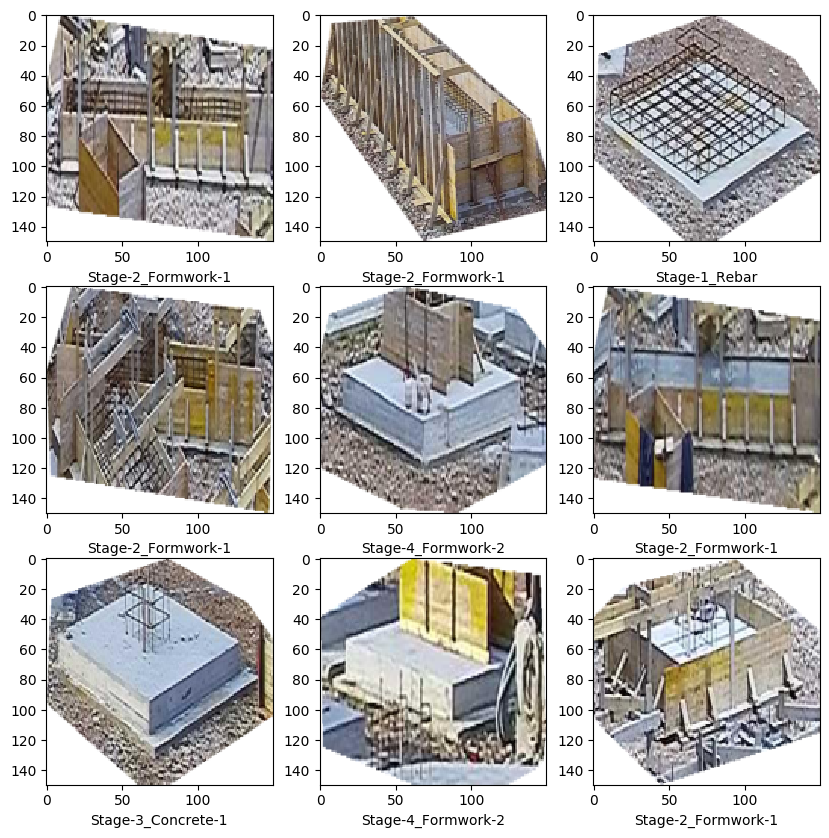

In [14]:
nrows=3
ncols=3
f, axs = plt.subplots(nrows, ncols, figsize=(10, 10))
for i in range(nrows):
    for j in range(ncols):
        # axs[i][j].xticks([])
        # axs[i][j].yticks([])
        axs[i][j].imshow(train_dataset[i*nrows + j][0].permute(1,2,0))
        axs[i][j].set_xlabel(class_labels_dict[train_dataset[i*nrows + j][1]])
plt.show()
# plt.imshow(image.permute(1, 2, 0))

In [34]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
from torch.utils.data import DataLoader
BATCH_SIZE = 16
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True) 

In [35]:
img_height = image_size
img_width = image_size
img_channels = 3
input_size = img_channels * img_height * img_width
sequence_length = BATCH_SIZE
input_shape = (sequence_length, img_height * img_width * img_channels)

In [38]:
input_size

67500

In [37]:
from models.lstm import LSTMModel
from torch import nn
import torch
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # outputs = model(inputs.view(BATCH_SIZE, sequence_length, -1))
        outputs = model(inputs.view(inputs.size(0), -1))
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/1, Loss: 1.5959007740020752


In [31]:
inputs.view(sequence_length, -1).shape

torch.Size([16, 67500])

In [28]:
inputs.reshape(input_shape).shape

torch.Size([16, 67500])

In [27]:
dummy_input = torch.randn((BATCH_SIZE, 3, 128, 128))

# Reshape the input
sequence_length = dummy_input.size(1)
dummy_input = dummy_input.view(BATCH_SIZE, sequence_length, -1)

In [30]:
dummy_input.shape

torch.Size([16, 3, 16384])

In [20]:
import numpy as np
import torch
batch_size=16

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=True
)
for step, (x,y) in enumerate(test_dataloader):
    break

In [21]:
x.shape

torch.Size([16, 3, 150, 150])

In [22]:
outputs_eval = model(x.view(sequence_length, -1))

In [23]:
import torch.nn.functional as F
pred = torch.max(F.softmax(outputs_eval),dim=1)
score = pred.values.tolist()
idx = pred.indices.tolist()

/home/akshay/miniconda3/envs/fleetsim/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


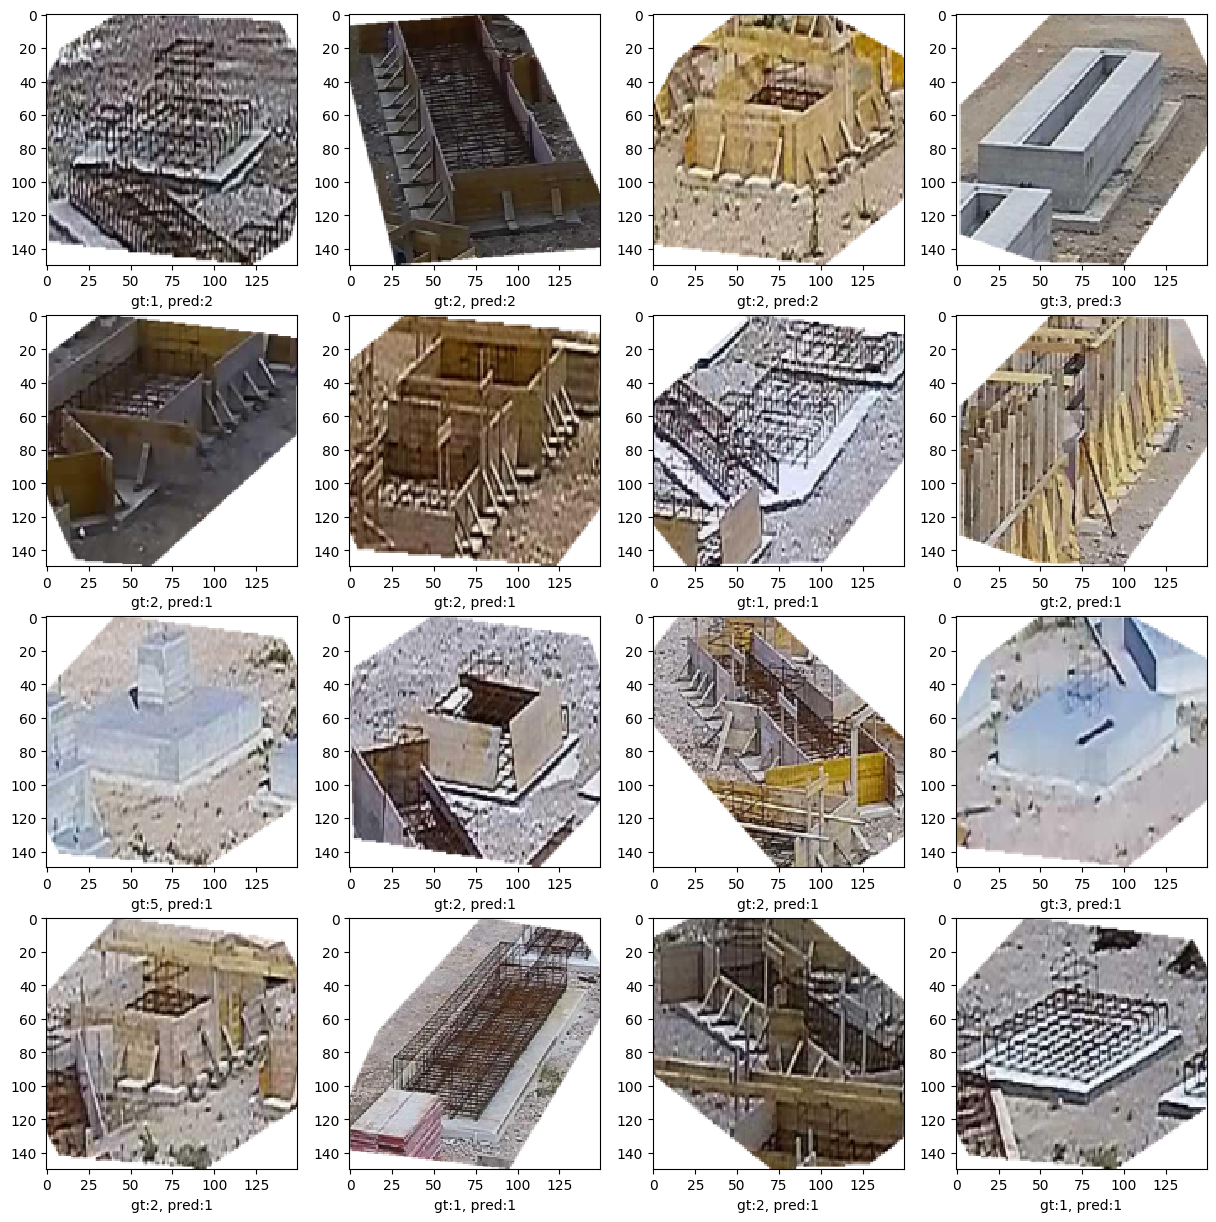

In [24]:
nrows=4
ncols=batch_size//nrows
f, axs = plt.subplots(nrows, ncols, figsize=(15, 15))
for i in range(nrows):
    for j in range(ncols):
        axs[i][j].imshow(x[i*ncols + j].permute(1,2,0))
#         axs[i][j].set_xlabel("gt:"+classifierModel.class_labels_dict[y[i*ncols + j].item()] 
#                              + ", pred:"+classifierModel.class_labels_dict[idx[i*ncols + j]])
        axs[i][j].set_xlabel("gt:"+str(y[i*ncols + j].item()) 
                            + ", pred:"+str(idx[i*ncols + j]))
plt.show()

import random
rand = random.randint(0, 20)
# plt.savefig("results/cnn/plots_bs"+str(batch_size)+"_seed_"+str(rand)+".png")